### Importing Relevant Packages

In [437]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

In [438]:
#defining path variable where datasets are present
file_path="C:/Users/HARITHA/Desktop/upgrad_mahee/"

#  Checkpoint 1: Data Understanding & Data Cleaning 

##### Importing dataset
##### we could see that ‘company_permalink’ column contains names of companies in various countries, and hence various languages.
##### Thus using encoder ISO-8859-1

In [439]:
companies= pd.read_csv(file_path+"companies.txt",sep="\t",engine='python',encoding="ISO-8859-1")
rounds2=pd.read_csv(file_path+"rounds2.csv",engine='python',encoding="ISO-8859-1")
mapping=pd.read_csv(file_path+"mapping.csv",engine='python')

###### converting values in permalink to lower case for analysis and find unique values and key column

In [440]:
companies['permalink']=companies['permalink'].str.lower()
print ("unique compaies in companies dataframe:{}".format(companies['permalink'].nunique()))
#In the companies data frame, which column can be used as the unique key for each company?
print("In the companies data frame, which column can be used as the unique key for each company?")
print("company_permalink")

unique compaies in companies dataframe:66368
In the companies data frame, which column can be used as the unique key for each company?
company_permalink


##### converting values in company_permalink to lower case for analysis and find unique values and key column

In [441]:
rounds2['company_permalink']=rounds2['company_permalink'].str.lower()
print ("unique compaies in rounds2 dataframe:{}".format(rounds2['company_permalink'].nunique()))

unique compaies in rounds2 dataframe:66370


In [442]:
#Are there any companies in the rounds2 file which are not present in companies?
print("Are there any companies in the rounds2 file which are not present in companies?")
DF1= pd.DataFrame(rounds2.company_permalink.unique())
DF2 = pd.DataFrame(companies.permalink.unique())
DF2.equals(DF1)
print("Y")

Are there any companies in the rounds2 file which are not present in companies?
Y


##### Merging two dataframes companies & rounds2 to master_frame

In [443]:
#How many observations are present in master_frame?
#Merging the dataframes to master_frame
#Renaming companies column permalink to company_permalink for merging
companies=companies.rename(columns={'permalink':'company_permalink'})
master_frame = pd.merge(rounds2,companies, how='left', on=['company_permalink'])

In [444]:
print ("master_frame shape :{}".format(master_frame.shape))
print("How many observations are present in master_frame?")
print(len(master_frame.index))

master_frame shape :(114949, 15)
How many observations are present in master_frame?
114949


## Cleaning Data 

##### Inspecting the Null values in percentage column-wise:

In [445]:
print(round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2))

company_permalink          0.000
funding_round_permalink    0.000
funding_round_type         0.000
funding_round_code        72.910
funded_at                  0.000
raised_amount_usd         17.390
name                       0.010
homepage_url               5.340
category_list              2.970
status                     0.010
country_code               7.550
state_code                 9.520
region                     8.840
city                       8.840
founded_at                17.860
dtype: float64


##### keeping only relevant data for analysis & Dropping columns which are not required for Spark funds analysis:

######### Here assumption made is that having so much of irrelevant data makes computation time larger. Thus removing 'funding_round_code','funding_round_permalink', 'funded_at','homepage_url', 'state_code','region','city','founded_at' columns and removing null records from category_list,country_code which are of no use for analysis.Also removing funding_round_type =undisclosed type as we are interested in only known sectors.

In [446]:
master_frame=master_frame.drop(columns=['funding_round_code','funding_round_permalink','funded_at','homepage_url', 'state_code','region','city','founded_at'],axis=1)
#Removing null rows present in country_code which are of no use for analysis:
master_frame=master_frame.dropna(subset = ['country_code'])
#Removing null rows present in category_list which are of no use for analysis:
master_frame=master_frame.dropna(subset = ['category_list'])
#Removing "undisclosed" values present in funding_round_type which are of no use for analysis:
master_frame.drop(master_frame[master_frame['funding_round_type'] == "undisclosed" ].index , inplace=True)
print ("master_frame shape :{}".format(master_frame.shape))

master_frame shape :(100572, 7)


##### Inspecting the Null values in percentage column-wise after deletion:

In [447]:
print(round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2))

company_permalink     0.000
funding_round_type    0.000
raised_amount_usd    13.310
name                  0.000
category_list         0.000
status                0.000
country_code          0.000
dtype: float64


###### Imputing raised_amount_usd with median as there is large percentage of null values in this column:

######## Assumption: Here imputing meadian is chosen as it is the most represented value for raised_amount_usd for each funding_round_type

In [448]:
print("null values before imputing the null values in raised_amount_usd column:")
print(sum(pd.isnull(master_frame['raised_amount_usd'])))
master_frame["raised_amount_usd"] = master_frame.groupby("funding_round_type").transform(lambda x: x.fillna(x.median()))
print("null values after imputing the null values in raised_amount_usd column:")
print(sum(pd.isnull(master_frame['raised_amount_usd'])))
print ("master_frame shape :{}".format(master_frame.shape))

null values before imputing the null values in raised_amount_usd column:
13388
null values after imputing the null values in raised_amount_usd column:
0
master_frame shape :(100572, 7)


##### Identifying outliers using scatter plots:

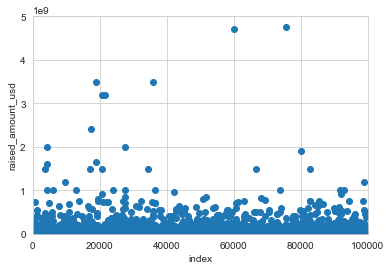

In [449]:
import matplotlib.pyplot as plt
import scipy, pylab
master_frame1 = master_frame.reset_index()
plt.scatter(master_frame1['index'],master_frame1['raised_amount_usd'])
# Set axis limits to show the markers completely
plt.xlabel('index')
plt.ylabel('raised_amount_usd')
plt.xlim(0, 100000)
plt.ylim(0, 5000000000)
plt.show()

###### removing outliers and again scatter plot to check the outliers,if any:

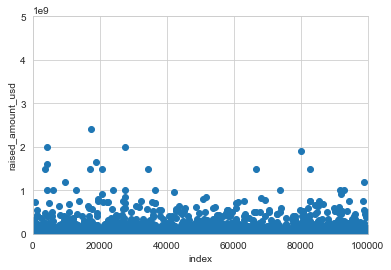

In [450]:
master_frame.drop(master_frame[(master_frame['raised_amount_usd'] >= 3000000000) ].index,inplace = True) 
master_frame1 = master_frame.reset_index()
plt.scatter(master_frame1['index'],master_frame1['raised_amount_usd'])
# Set axis limits to show the markers completely
plt.xlabel('index')
plt.ylabel('raised_amount_usd')
plt.xlim(0, 100000)
plt.ylim(0, 5000000000) 
plt.show()

In [451]:
#master_frame observations we are left with after removing outliers with scatter plot
print("Master_frame shape after removing outliers")
print ("master_frame shape :{}".format(master_frame.shape))

Master_frame shape after removing outliers
master_frame shape :(100561, 7)


###### Calculating z-score 

In [452]:
#Calculating z-score to perform cleanup:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(master_frame['raised_amount_usd'] ))
print(z)

[0.03613028 0.09019702 0.1988385  ... 0.21548053 0.21569456 0.2160647 ]


##### removing outliers using z-score:
##### here threshold is considered as -3 < z < 3 as this is the standard range for z-score where the data has not much effect on analysis.

In [453]:
threshold = 3
master_frame= master_frame[(z < 3)]
print ("master_frame shape :{}".format(master_frame.shape))

master_frame shape :(99818, 7)


In [454]:
#Master_frame used for our analysis is represented here (first 5 in 99818 rows with 7 columns of master_frame):
master_frame.head(5)

,company_permalink,funding_round_type,raised_amount_usd,name,category_list,status,country_code
0,/organization/-fame,venture,10000000.000,#fame,Media,operating,IND
1,/organization/-qounter,venture,5000000.000,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA
2,/organization/-qounter,seed,700000.000,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA
4,/organization/0-6-com,venture,2000000.000,0-6.com,Curated Web,operating,CHN
5,/organization/004-technologies,venture,5000000.000,004 Technologies,Software,operating,USA


# Checkpoint 2: Funding Type Analysis

##### Observing the count of each funding type :

In [455]:
funding_rounds=master_frame['funding_round_type'].value_counts().rename_axis('funding_type').to_frame('count_of_investments')
funding_rounds

,count_of_investments
funding_type,
venture,51745
seed,26436
debt_financing,6578
angel,5416
equity_crowdfunding,2970
grant,1990
private_equity,1812
convertible_note,1632
post_ipo_equity,548


#### Considering four types of funding i.e., seed,angel,venture,private_equity required for table 2.1

In [456]:
master_frame=master_frame.loc[(master_frame['funding_round_type'] == "venture") | (master_frame['funding_round_type'] == "seed")
                             | (master_frame['funding_round_type'] == "angel") | (master_frame['funding_round_type'] == "private_equity")]
master_frame.head(5)

,company_permalink,funding_round_type,raised_amount_usd,name,category_list,status,country_code
0,/organization/-fame,venture,10000000.000,#fame,Media,operating,IND
1,/organization/-qounter,venture,5000000.000,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA
2,/organization/-qounter,seed,700000.000,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA
4,/organization/0-6-com,venture,2000000.000,0-6.com,Curated Web,operating,CHN
5,/organization/004-technologies,venture,5000000.000,004 Technologies,Software,operating,USA


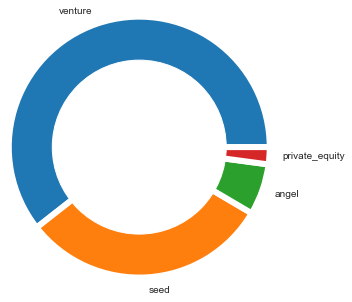

venture           51745
seed              26436
angel              5416
private_equity     1812
Name: funding_round_type, dtype: int64


In [457]:
# Create a pieplot
round_types = master_frame.funding_round_type.value_counts()
plt.pie(round_types.values, labels=round_types.index, radius=1.5, wedgeprops = { 'linewidth' : 6, 'edgecolor' : 'white' })
# add a circle at the center
my_circle=plt.Circle( (0,0), 1, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
print(round_types)

## master_frame1 used later for checkpoint6: Plot 1

In [458]:
master_frame1=master_frame.loc[(master_frame['funding_round_type'] == "venture") | (master_frame['funding_round_type'] == "seed")
                             | (master_frame['funding_round_type'] == "angel") | (master_frame['funding_round_type'] == "private_equity")]

##### calculating Average funding amount for each of the four funding types.

In [459]:
pd.options.display.float_format='{:.3f}'.format
mean_invest=round(master_frame.groupby('funding_round_type')['raised_amount_usd'].mean(),2).to_frame('amount_invested')
mean_invest

,amount_invested
funding_round_type,
angel,775918.120
private_equity,28715518.640
seed,644863.360
venture,9313410.180


### Retaining only rows with venture type of funding as Spark Funds wants to invest in between 5 million to 15 million USD :

In [460]:
master_frame = master_frame[master_frame['funding_round_type'] == 'venture']
print ("master_frame shape :{}".format(master_frame.shape))
master_frame.head(5)

master_frame shape :(51745, 7)


,company_permalink,funding_round_type,raised_amount_usd,name,category_list,status,country_code
0,/organization/-fame,venture,10000000.000,#fame,Media,operating,IND
1,/organization/-qounter,venture,5000000.000,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA
4,/organization/0-6-com,venture,2000000.000,0-6.com,Curated Web,operating,CHN
5,/organization/004-technologies,venture,5000000.000,004 Technologies,Software,operating,USA
8,/organization/0ndine-biomedical-inc,venture,719491.000,Ondine Biomedical Inc.,Biotechnology,operating,CAN


# Checkpoint 3: Country Analysis

In [461]:
#top9 data frame with the top nine countries based on the total investment amount each country has received:
top9=master_frame.groupby('country_code').sum().sort_values(by = ['raised_amount_usd'], ascending=[False])
top9.head(9)

,raised_amount_usd
country_code,
USA,358273089090.000
CHN,27657918773.000
GBR,19009209004.000
IND,11060808720.000
CAN,9742217668.000
ISR,7259350477.000
DEU,7231744618.000
FRA,6665329408.000
CHE,3061560264.000


###### top9-Dataframe of top 9 countries with highest funding amount

In [462]:
top9 = master_frame[master_frame['country_code'].isin(['USA','CHN','GBR','IND','CAN','ISR','FRA','DEU','CHE' ])]
top9.head(5)

,company_permalink,funding_round_type,raised_amount_usd,name,category_list,status,country_code
0,/organization/-fame,venture,10000000.000,#fame,Media,operating,IND
1,/organization/-qounter,venture,5000000.000,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA
4,/organization/0-6-com,venture,2000000.000,0-6.com,Curated Web,operating,CHN
5,/organization/004-technologies,venture,5000000.000,004 Technologies,Software,operating,USA
8,/organization/0ndine-biomedical-inc,venture,719491.000,Ondine Biomedical Inc.,Biotechnology,operating,CAN


###### Getting the Top 3 English-Speaking Countries from wiki

In [372]:
EngSpkCon = pd.read_html('https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language')[1]
EngSpkCon['Alpha-3 code'].head(5)

0    ATG
1    BHS
2    BRB
3    BLZ
4    BWA
Name: Alpha-3 code, dtype: object

##### Selecting top 9 countries with the highest investment amount  and for only Venture Funding Type(FT)

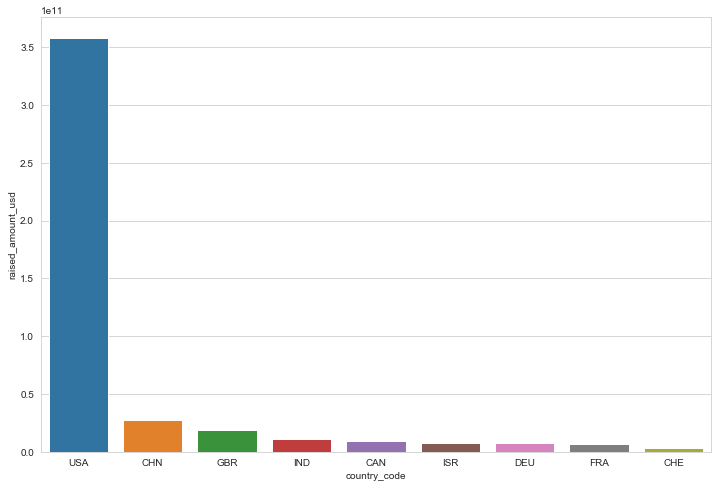

              raised_amount_usd
country_code                   
USA            358273089090.000
CHN             27657918773.000
GBR             19009209004.000
IND             11060808720.000
CAN              9742217668.000
ISR              7259350477.000
DEU              7231744618.000
FRA              6665329408.000
CHE              3061560264.000 

Top 3 english speaking countries in order are: USA, GBR, IND


In [463]:
 top9 = master_frame[master_frame['funding_round_type']=='venture'].groupby('country_code').sum().sort_values('raised_amount_usd', ascending=False).head(9)
plt.figure(figsize=(12, 8))
sns.barplot(x=top9.index, y=top9.values.ravel())
plt.ylabel('raised_amount_usd')
plt.show()

print(top9, '\n')
print("Top 3 english speaking countries in order are: USA, GBR, IND")

In [464]:
#Based on the list given in https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language:
#Top 3 English-Speaking Countries:
print("Top 3 English-Speaking Countries are:\n 1.USA\n 2.GBR\n 3.IND")

Top 3 English-Speaking Countries are:
 1.USA
 2.GBR
 3.IND


# Checkpoint 4: Sector Analysis 1

##### Derive the primary sector values from category list in the master_frame
###### Here,considering the value before first vertical bar(\|) as primary sector according to business

In [465]:
master_frame=master_frame.assign(primary_sector=master_frame.category_list.str.split("|").str[0])
master_frame=master_frame.rename(columns={'primary_sector':'primary sector'})
print ("master_frame shape :{}".format(master_frame.shape))
master_frame.head(5)

master_frame shape :(51745, 8)


,company_permalink,funding_round_type,raised_amount_usd,name,category_list,status,country_code,primary sector
0,/organization/-fame,venture,10000000.000,#fame,Media,operating,IND,Media
1,/organization/-qounter,venture,5000000.000,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA,Application Platforms
4,/organization/0-6-com,venture,2000000.000,0-6.com,Curated Web,operating,CHN,Curated Web
5,/organization/004-technologies,venture,5000000.000,004 Technologies,Software,operating,USA,Software
8,/organization/0ndine-biomedical-inc,venture,719491.000,Ondine Biomedical Inc.,Biotechnology,operating,CAN,Biotechnology


##### Observing the mapping.csv file:

In [466]:
mapping.head(10)

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1
5,Active Lifestyle,0,0,0,0,1,0,0,0,0
6,Ad Targeting,0,0,0,0,0,0,0,0,1
7,Advanced Materials,0,0,0,0,0,1,0,0,0
8,Adventure Travel,1,0,0,0,0,0,0,0,0
9,Advertising,0,0,0,0,0,0,0,0,1


### reshaping the mapping dataframe using melt function to unpivot the dataframe & preparing data to merge with master_frame:

In [467]:
df_unpivoted= mapping.melt(id_vars=['category_list'],value_vars =['Manufacturing','Automotive & Sports','Cleantech / Semiconductors','Entertainment','Health','News, Search and Messaging','Others','Social, Finance, Analytics, Advertising'])
mapping=df_unpivoted.loc[(df_unpivoted['value'] == 1) ]

#### Cleaning mapping table and manipulating data:

In [468]:
mapping=mapping.drop(columns=['value'])
#replacing data '0' with 'na'
mapping.loc[mapping['category_list'] == "A0lytics"]
#renaming the columns names to merge with master_frame
mapping=mapping.rename(columns={'variable':'main_sector','category_list':'primary sector'})
mapping=mapping.replace(to_replace='0',value='na',regex=True)
print ("unique variables in main_sector :{}".format(mapping['main_sector'].nunique()))
mapping.head(7)

unique variables in main_sector :8


,primary sector,main_sector
1,3D,Manufacturing
2,3D Printing,Manufacturing
3,3D Technology,Manufacturing
7,Advanced Materials,Manufacturing
15,Agriculture,Manufacturing
34,Architecture,Manufacturing
55,Batteries,Manufacturing


#### Code for a merged data frame with each primary sector mapped to its main sector
##### merging mapping dataframe with master_frame to get the main sectors:

In [469]:
#shape of master_frame before merging
print ("master_frame shape :{}".format(master_frame.shape))
master_frame = pd.merge(master_frame,mapping,how='left', on=['primary sector'])
#shape of master_frame after merging
print ("master_frame shape :{}".format(master_frame.shape))
print ("unique variables in main_sector :{}".format(mapping['main_sector'].nunique()))

master_frame shape :(51745, 8)
master_frame shape :(51745, 9)
unique variables in main_sector :8


##### create a new data frame with only these 3 countires data for furthur sector wise analysis

In [470]:
top3_englishspkcntr = master_frame[master_frame['country_code'].isin(['USA', 'GBR', 'IND'])]

##### checking for null values in main_sector of master_frame and removing them

Null values in main_sector: 201
Removed records with null values in main_sector 


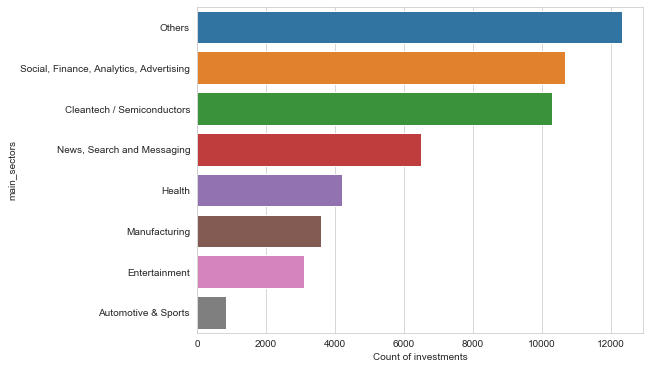

Others                                     12338
Social, Finance, Analytics, Advertising    10674
Cleantech / Semiconductors                 10293
News, Search and Messaging                  6505
Health                                      4219
Manufacturing                               3593
Entertainment                               3095
Automotive & Sports                          827
Name: main_sector, dtype: int64


In [471]:
print("Null values in main_sector: {}".format(len(master_frame[master_frame.main_sector.isnull()])))
master_frame= master_frame[~(master_frame.main_sector.isnull())]
print("Removed records with null values in main_sector ")
master_frame.shape
sectors = master_frame.main_sector.value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sectors.values, y=sectors.index)
plt.ylabel('main_sectors')
plt.xlabel('Count of investments')
plt.show()

print(sectors)

# Checkpoint 5: Sector Analysis 2

## Country-Wise Sector Analysis

#### Creating the three country-wise data frame filtered  funding amount range 5-5M USD 

###### Country 1 - USA

In [472]:
d1 = master_frame[(master_frame['country_code'] == 'USA') & 
             (master_frame['raised_amount_usd'] >= 5000000) & 
             (master_frame['raised_amount_usd'] <= 15000000)]
D1_grouped = d1[['raised_amount_usd','main_sector']].groupby('main_sector').agg(['sum', 'count']).rename(
    columns={'sum':'Total Amount Invested','count' : 'Total No.of Investments'})
D1 = d1.merge(D1_grouped, how='left', on ='main_sector')
D1.head()

,company_permalink,funding_round_type,raised_amount_usd,name,category_list,status,country_code,primary sector,main_sector,"(raised_amount_usd, Total Amount Invested)","(raised_amount_usd, Total No.of Investments)"
0,/organization/-qounter,venture,5000000.000,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA,Application Platforms,"News, Search and Messaging",15269567428.000,1844
1,/organization/004-technologies,venture,5000000.000,004 Technologies,Software,operating,USA,Software,Others,28586007002.000,3403
2,/organization/0xdata,venture,8900000.000,H2O.ai,Analytics,operating,USA,Analytics,"Social, Finance, Analytics, Advertising",26687376964.000,3290
3,/organization/1-mainstream,venture,5000000.000,1 Mainstream,Apps|Cable|Distribution|Software,acquired,USA,Apps,"News, Search and Messaging",15269567428.000,1844
4,/organization/1000museums-com,venture,5000000.000,1000museums.com,Curated Web,operating,USA,Curated Web,"News, Search and Messaging",15269567428.000,1844


### Country2 - GBR

In [473]:
d2 = master_frame[(master_frame['country_code'] == 'GBR') & 
             (master_frame['raised_amount_usd'] >= 5000000) & 
             (master_frame['raised_amount_usd'] <= 15000000)]
D2_grouped = d2[['raised_amount_usd','main_sector']].groupby('main_sector').agg(['sum', 'count']).rename(
    columns={'sum':'Total Amount Invested','count' : 'Total No.of Investments'})
D2 = d2.merge(D2_grouped, how='left', on ='main_sector')
D2.head()

,company_permalink,funding_round_type,raised_amount_usd,name,category_list,status,country_code,primary sector,main_sector,"(raised_amount_usd, Total Amount Invested)","(raised_amount_usd, Total No.of Investments)"
0,/organization/365scores,venture,5500000.000,365Scores,Android|Apps|iPhone|Mobile|Sports,operating,GBR,Android,"Social, Finance, Analytics, Advertising",1389404014.000,193
1,/organization/7digital,venture,8468328.000,7digital,Content Creators|Content Delivery|Licensing|Mu...,acquired,GBR,Content Creators,Entertainment,602784687.000,80
2,/organization/7digital,venture,10000000.000,7digital,Content Creators|Content Delivery|Licensing|Mu...,acquired,GBR,Content Creators,Entertainment,602784687.000,80
3,/organization/90min,venture,15000000.000,90min,Media|News|Publishing|Soccer|Sports,operating,GBR,Media,Entertainment,602784687.000,80
4,/organization/90min,venture,5800000.000,90min,Media|News|Publishing|Soccer|Sports,operating,GBR,Media,Entertainment,602784687.000,80


### Country 3- IND

In [474]:
d3 = master_frame[(master_frame['country_code'] == 'IND') & 
             (master_frame['raised_amount_usd'] >= 5000000) & 
             (master_frame['raised_amount_usd'] <= 15000000)]
D3_grouped = d3[['raised_amount_usd','main_sector']].groupby('main_sector').agg(['sum', 'count']).rename(
    columns={'sum':'Total Amount Invested','count' : 'Total No.of Investments'})
D3 = d3.merge(D3_grouped, how='left', on ='main_sector')
D3.head()

,company_permalink,funding_round_type,raised_amount_usd,name,category_list,status,country_code,primary sector,main_sector,"(raised_amount_usd, Total Amount Invested)","(raised_amount_usd, Total No.of Investments)"
0,/organization/-fame,venture,10000000.000,#fame,Media,operating,IND,Media,Entertainment,350830000.000,47
1,/organization/1000lookz,venture,5000000.000,1000Lookz,Beauty,operating,IND,Beauty,Health,237740000.000,33
2,/organization/21diamonds-india,venture,6369507.000,21Diamonds,E-Commerce,operating,IND,E-Commerce,Others,1253409507.000,158
3,/organization/99games-online-private-limited,venture,5000000.000,99Games Online Private Limited,Games,operating,IND,Games,Entertainment,350830000.000,47
4,/organization/a-little-world,venture,6410000.000,A LITTLE WORLD,Finance,operating,IND,Finance,"Social, Finance, Analytics, Advertising",780549550.000,106


#### Total count of investments made in Top-3 countries each:

In [475]:
print(" Total number of investments in USA(United States 'C1')):{}".format(D1.raised_amount_usd.count()))

print(" Total number of investments in GBR(United Kingdom 'C2'):{}".format(D2.raised_amount_usd.count()))

print(" Total number of investments in IND(India 'C3'):{}".format(D3.raised_amount_usd.count()))


 Total number of investments in USA(United States 'C1')):14095
 Total number of investments in GBR(United Kingdom 'C2'):842
 Total number of investments in IND(India 'C3'):493


#### Total amount of Investment made in Top-3 countries each:

In [476]:
print("Total amount of investment in USA(United States):{}".format(round(D1.raised_amount_usd.sum(), 2)))

print("Total amount of investment in GBR(United Kingdom):{}".format(round(D2.raised_amount_usd.sum(), 2)))

print("Total amount of investment in IND(India):{}".format(round(D3.raised_amount_usd.sum(), 2)))

Total amount of investment in USA(United States):117733294664.0
Total amount of investment in GBR(United Kingdom):6480228300.0
Total amount of investment in IND(India):3774543602.0


##### Top sector,Second-best sector,Third-best sector In D1(USA)(based on count of investments):
#### Number of investments in the top sector,Second-best sector,Third-best sector In D1

In [477]:
D1_grouped

raised_amount_usd  \
                                        Total Amount Invested   
main_sector                                                     
Automotive & Sports                            1759104361.000   
Cleantech / Semiconductors                    22526628192.000   
Entertainment                                  5764197982.000   
Health                                         8931859357.000   
Manufacturing                                  8208553378.000   
News, Search and Messaging                    15269567428.000   
Others                                        28586007002.000   
Social, Finance, Analytics, Advertising       26687376964.000   

                                                                 
                                        Total No.of Investments  
main_sector                                                      
Automotive & Sports                                         228  
Cleantech / Semiconductors                                 2564  
Entertainment                                               724  
Health                                                     1053  
Manufacturing                                               989  
News, Search and Messaging                                 1844  
Others                                                     3403  
Social, Finance, Analytics, Advertising                    3290

#### Top sector,Second-best sector,Third-best sector In D2(GBR)(based on count of investments):
#### Number of investments in the top sector,Second-best sector,Third-best sector In D2

In [478]:
D2_grouped

raised_amount_usd  \
                                        Total Amount Invested   
main_sector                                                     
Automotive & Sports                             217051565.000   
Cleantech / Semiconductors                     1265139665.000   
Entertainment                                   602784687.000   
Health                                          254537510.000   
Manufacturing                                   411940335.000   
News, Search and Messaging                      735746235.000   
Others                                         1603624289.000   
Social, Finance, Analytics, Advertising        1389404014.000   

                                                                 
                                        Total No.of Investments  
main_sector                                                      
Automotive & Sports                                          26  
Cleantech / Semiconductors                                  151  
Entertainment                                                80  
Health                                                       32  
Manufacturing                                                52  
News, Search and Messaging                                   97  
Others                                                      211  
Social, Finance, Analytics, Advertising                     193

#### Top sector,Second-best sector,Third-best sector In D3(IND)(based on count of investments):
#### Number of investments in the top sector,Second-best sector,Third-best sector In D3

In [479]:
D3_grouped

raised_amount_usd  \
                                        Total Amount Invested   
main_sector                                                     
Automotive & Sports                             141900000.000   
Cleantech / Semiconductors                      210380000.000   
Entertainment                                   350830000.000   
Health                                          237740000.000   
Manufacturing                                   245900000.000   
News, Search and Messaging                      553834545.000   
Others                                         1253409507.000   
Social, Finance, Analytics, Advertising         780549550.000   

                                                                 
                                        Total No.of Investments  
main_sector                                                      
Automotive & Sports                                          14  
Cleantech / Semiconductors                                   29  
Entertainment                                                47  
Health                                                       33  
Manufacturing                                                30  
News, Search and Messaging                                   76  
Others                                                      158  
Social, Finance, Analytics, Advertising                     106

##### For the top sector in D1(USA) which company received the highest investment?

In [480]:
company1 = D1[D1['main_sector']=='Others']
company1 = company1.pivot_table(values = 'raised_amount_usd', index = 'name', aggfunc = 'sum')
company1 = company1.sort_values(by = 'raised_amount_usd', ascending = False)
print('For the top sector in D1(USA) below company received the highest investment')
print(company1.head(1))
print('\n')

For the top sector in D1(USA) below company received the highest investment
             raised_amount_usd
name                          
Virtustream       64300000.000




#### For the second top sector in D1(USA) which company received the highest investment?

In [481]:
company2 = D1[D1['main_sector']=='Social, Finance, Analytics, Advertising']
company2 = company2.pivot_table(values = 'raised_amount_usd', index = 'name', aggfunc = 'sum')
company2 = company2.sort_values(by = 'raised_amount_usd', ascending = False)
print('For the Second top sector in D1(USA) below company received the highest investment')
print(company2.head(1))

For the Second top sector in D1(USA) below company received the highest investment
                                 raised_amount_usd
name                                              
SST Inc. (Formerly ShotSpotter)       67933006.000


#### For the top sector in D2(GBR) which company received the highest investment?

In [482]:
company1 = D2[D2['main_sector']=='Others']
company1 = company1.pivot_table(values = 'raised_amount_usd', index = 'name', aggfunc = 'sum')
company1 = company1.sort_values(by = 'raised_amount_usd', ascending = False)
print('For the top sector in D2(GBR) below company received the highest investment')
print(company1.head(1))
print('\n')

For the top sector in D2(GBR) below company received the highest investment
                raised_amount_usd
name                             
Electric Cloud       37000000.000




#### For the second top sector in D2(GBR) which company received the highest investment?

In [483]:
company2 = D2[D2['main_sector']=='Social, Finance, Analytics, Advertising']
company2 = company2.pivot_table(values = 'raised_amount_usd', index = 'name', aggfunc = 'sum')
company2 = company2.sort_values(by = 'raised_amount_usd', ascending = False)
print('For the Second top sector in D2(GBR) below company received the highest investment')
print(company2.head(1))

For the Second top sector in D2(GBR) below company received the highest investment
      raised_amount_usd
name                   
Zopa       37900000.000


##### For the top sector in D3(IND) which company received the highest investment?

In [484]:
company1 = D3[D3['main_sector']=='Others']
company1 = company1.pivot_table(values = 'raised_amount_usd', index = 'name', aggfunc = 'sum')
company1 = company1.sort_values(by = 'raised_amount_usd', ascending = False)
print('For the top sector in D3(IND) below company received the highest investment')
print(company1.head(1))
print('\n')

For the top sector in D3(IND) below company received the highest investment
              raised_amount_usd
name                           
FirstCry.com       39000000.000




#### For the second top sector in D3(IND) which company received the highest investment?

In [485]:
company2 = D3[D3['main_sector']=='News, Search and Messaging']
company2 = company2.pivot_table(values = 'raised_amount_usd', index = 'name', aggfunc = 'sum')
company2 = company2.sort_values(by = 'raised_amount_usd', ascending = False)
print('For the Second top sector in D3(IND) below company received the highest investment')
print(company2.head(1))

For the Second top sector in D3(IND) below company received the highest investment
         raised_amount_usd
name                      
GupShup       33000000.000


#### create a new data frame with only these 3 countires data & top3 main sectors for furthur sector wise analysis

In [486]:
top3_englishspkcntr=top3_englishspkcntr[top3_englishspkcntr['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising',
                                                                              'Cleantech / Semiconductors','News, Search and Messaging'])]
top3_englishspkcntr.head(5) 

,company_permalink,funding_round_type,raised_amount_usd,name,category_list,status,country_code,primary sector,main_sector
1,/organization/-qounter,venture,5000000.000,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA,Application Platforms,"News, Search and Messaging"
3,/organization/004-technologies,venture,5000000.000,004 Technologies,Software,operating,USA,Software,Others
5,/organization/0xdata,venture,20000000.000,H2O.ai,Analytics,operating,USA,Analytics,"Social, Finance, Analytics, Advertising"
6,/organization/0xdata,venture,1700000.000,H2O.ai,Analytics,operating,USA,Analytics,"Social, Finance, Analytics, Advertising"
7,/organization/0xdata,venture,8900000.000,H2O.ai,Analytics,operating,USA,Analytics,"Social, Finance, Analytics, Advertising"


# Checkpoint 6: Plot1

##### plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity, and the average amount of investment in each funding type.

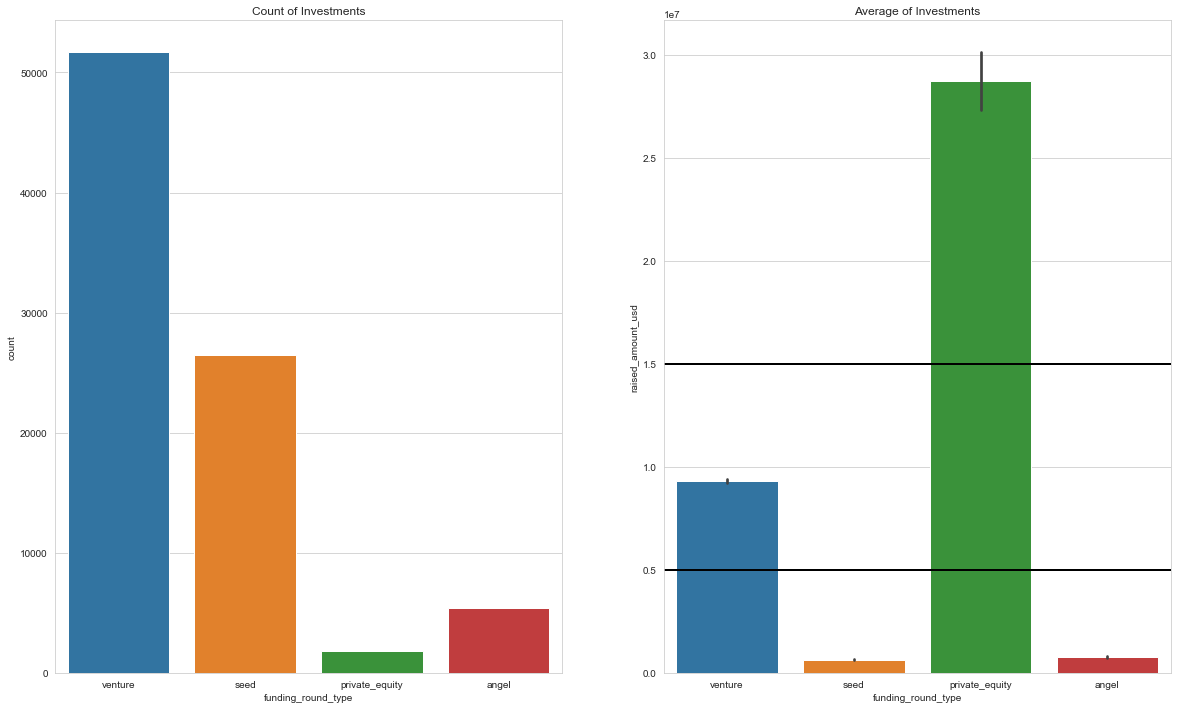

In [487]:
# set a seaborn background style
sns.set_style("whitegrid")
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
sns.countplot(x="funding_round_type", data=master_frame1)
plt.title("Count of Investments")
plt.subplot(1, 2, 2)
sns.barplot(y='raised_amount_usd', x="funding_round_type", data=master_frame1, estimator=np.mean)
plt.title("Average of Investments")
plt.axhline(y=5000000, linewidth=2, color = 'k')
plt.axhline(y=15000000, linewidth=2, color = 'k')
plt.show()

# Checkpoint 6: Plot2

###### plot showing the top 9 countries against the total amount of investments of funding type FT,here FT=venture

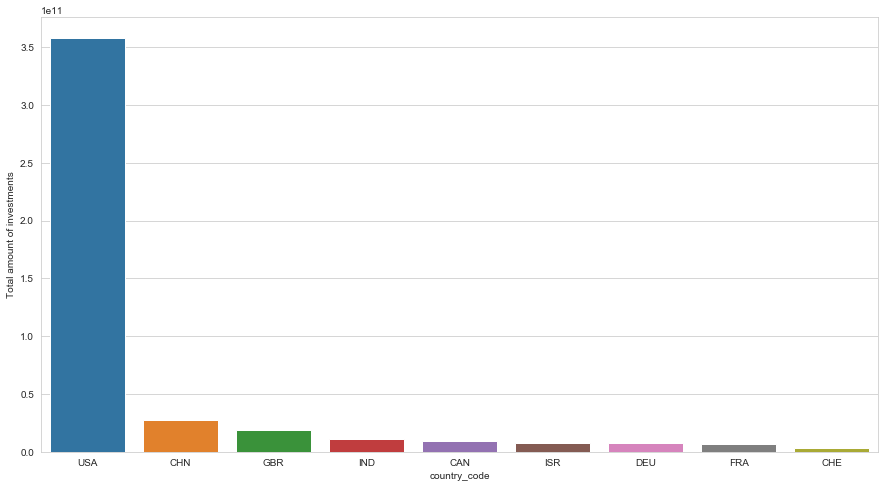

In [488]:
plt.figure(figsize=(15, 8))
sns.barplot(x=top9.index, y=top9.values.ravel())
plt.ylabel("Total amount of investments")
plt.show()

# Checkpoint 6: Plot3

##### plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT)

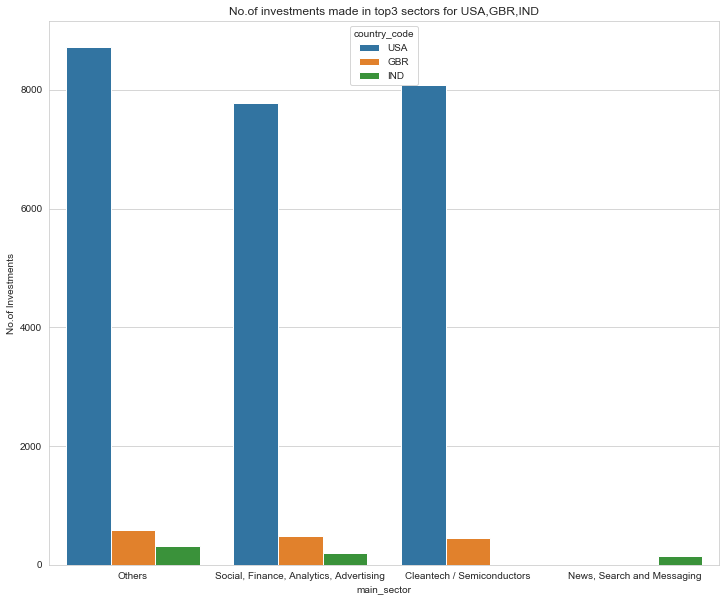

In [491]:
top3_englishspkcntr.drop(top3_englishspkcntr[(top3_englishspkcntr['main_sector'] == "News, Search and Messaging") & ((top3_englishspkcntr['country_code'] == "USA") | (top3_englishspkcntr['country_code'] == "GBR"))  ].index , inplace=True)
top3_englishspkcntr.drop(top3_englishspkcntr[(top3_englishspkcntr['main_sector'] == "Cleantech / Semiconductors") & (top3_englishspkcntr['country_code'] == "IND") ].index , inplace=True)
plt.figure(figsize=(12, 10))
sns.countplot(x='main_sector', hue="country_code", data=top3_englishspkcntr)
plt.ylabel('No.of Investments')
plt.title("No.of investments made in top3 sectors for USA,GBR,IND")
plt.show()
